Skin Cancer Dataset Path: /kaggle/input/skin-cancer9-classesisic
Pneumonia Dataset Path: /kaggle/input/chest-xray-pneumonia
Found 1886 images belonging to 1 classes.
Found 471 images belonging to 1 classes.
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training Skin Cancer Detection Model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.9599 - loss: 0.1220 - val_accuracy: 1.0000 - val_loss: 2.1196e-04
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 1.0000 - loss: 5.1162e-04 - val_accuracy: 1.0000 - val_loss: 4.3396e-05
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 1.0000 - loss: 2.4894e-04 - val_accuracy: 1.0000 - val_loss: 1.8885e-05
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 1.0000 - loss: 1.6263e-04 - val_accuracy: 1.0000 - val_loss: 9.9236e-06
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 1.0000 - loss: 1.4677e-04 - val_accuracy: 1.0000 - val_loss: 5.5871e-06
Training Pneumonia Detection Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.7792 - loss: 0.5072 - val_accuracy: 0.9166 - val_loss: 0.2161
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9225 - loss: 0.2004 - val_accuracy: 0.9511 - val_loss: 0.1292
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.9505 - loss: 0.1378 - val_accuracy: 0.9597 - val_loss: 0.1089
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9508 - loss: 0.1321 - val_accuracy: 0.9578 - val_loss: 0.1086
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9648 - loss: 0.0996 - val_accuracy: 0.9664 - val_loss: 0.0857


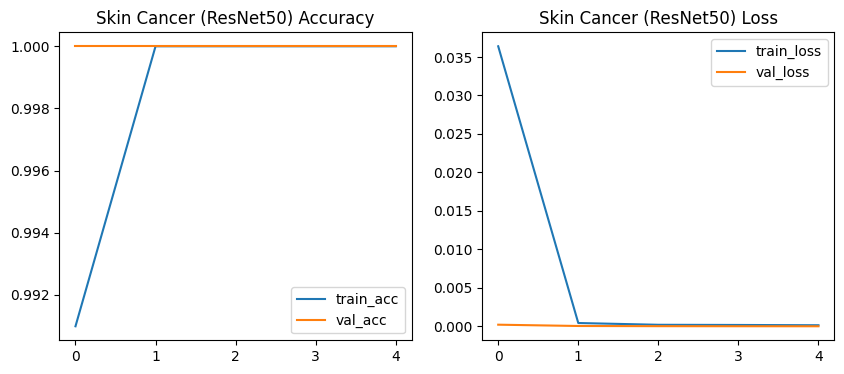

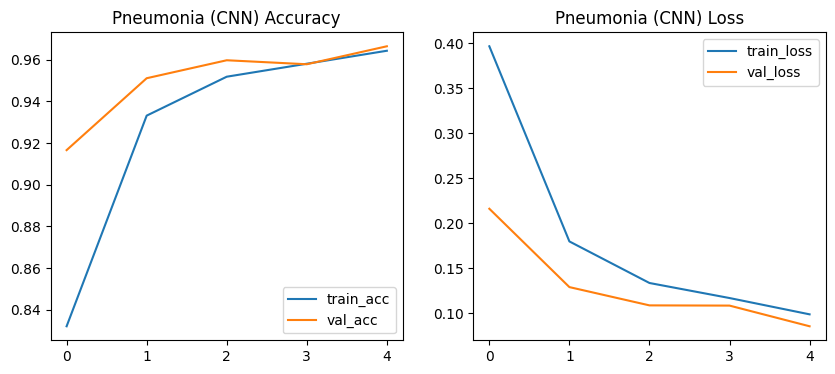

✅ Training Completed Successfully!


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# ======================================
# Download datasets via KaggleHub
# ======================================
skin_path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")
pneumonia_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Skin Cancer Dataset Path:", skin_path)
print("Pneumonia Dataset Path:", pneumonia_path)

# ======================================
# Parameters
# ======================================
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 5   # keep small for demo, can increase

# ======================================
# Data Generators
# ======================================
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# --- Skin Cancer Dataset ---
skin_train = data_gen.flow_from_directory(
    os.path.join(skin_path),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',   # binary classification
    subset='training'
)

skin_val = data_gen.flow_from_directory(
    os.path.join(skin_path),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# --- Pneumonia Dataset ---
pneumonia_train = data_gen.flow_from_directory(
    os.path.join(pneumonia_path, "chest_xray/train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

pneumonia_val = data_gen.flow_from_directory(
    os.path.join(pneumonia_path, "chest_xray/train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# ======================================
# Skin Cancer Detection (ResNet50)
# ======================================
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128,128,3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

skin_model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False

skin_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

print("Training Skin Cancer Detection Model...")
skin_history = skin_model.fit(skin_train, validation_data=skin_val, epochs=EPOCHS)

# ======================================
# Pneumonia Detection (Simple CNN)
# ======================================
pneumonia_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

pneumonia_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

print("Training Pneumonia Detection Model...")
pneumonia_history = pneumonia_model.fit(pneumonia_train, validation_data=pneumonia_val, epochs=EPOCHS)

# ======================================
# Evaluation Plots
# ======================================
def plot_history(history, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="train_acc")
    plt.plot(history.history['val_accuracy'], label="val_acc")
    plt.title(f"{title} Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="train_loss")
    plt.plot(history.history['val_loss'], label="val_loss")
    plt.title(f"{title} Loss")
    plt.legend()
    plt.show()

plot_history(skin_history, "Skin Cancer (ResNet50)")
plot_history(pneumonia_history, "Pneumonia (CNN)")

print("✅ Training Completed Successfully!")
